In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-11-11 15:55:09.673362: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-11-11 15:55:16.093045: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-11-11 15:55:16.134167: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-11-11 15:55:16.134203: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-11-11 15:55:16.136296: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-11-11 15:55:16.138376: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

# Load Koch Meinhardt dataset


In [2]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_3/Koch_Meinhardt_3.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_3/simulation.txt")
with open(data_path, 'r') as f:
    simulation = eval(f.read()) 

t_star = np.linspace(simulation.t_start, simulation.t_end, simulation.t_steps)

#t_star = t_star[32*1::64]
#data = data[...,32*1::64]
t_star = t_star[32*6::64]
data = data[...,32*6::64]


T = t_star.shape[0]    
    
L = simulation.L[0]
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

#alpha_u = 1/(np.max(data[0, ...]))
#alpha_v = 1/(np.max(data[1, ...]))
#alpha_u = 10
#alpha_v = 10

#data[0, ...] = data[0, ...]*alpha_u
#data[1, ...] = data[1, ...]*alpha_v

In [3]:
T

4

In [4]:
model_params = {'training_data_size': T*N,#T*32,
                'pde_data_size': (T*N),#//(32),
                #'boundary_data_size':((x_size + y_size)*T)//(8),
                'signal_to_noise':0.00,
                'shuffle':False}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = dataset['obs_input']
obs_Y = dataset['obs_output']
pde_X = dataset['pde']

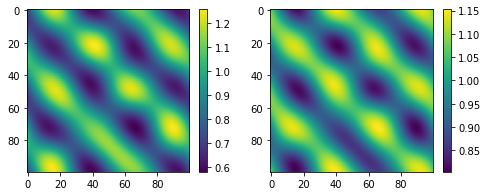

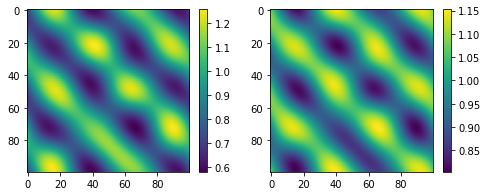

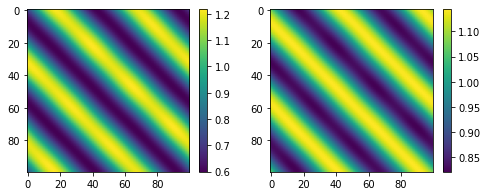

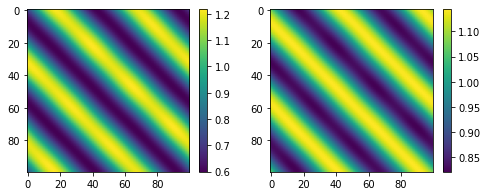

In [5]:
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, 0])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, 0])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(obs_Y[0:N, 0].reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(obs_Y[0:N, 1].reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, -1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, -1])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(obs_Y[(T-1)*N:, 0].reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(obs_Y[(T-1)*N:, 1].reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

In [6]:
ds = TINN_Dataset(obs_X, obs_Y)#, pde_X)

In [7]:
ds.x_pde_size

40000

In [8]:
layers = [3, 512, 512, 512, 512, 2]
pinnKM = tu.NN(layers, lb, ub, dtype=tf.float64)
pde_resKM = Koch_Meinhard(
                    D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, simulation.Ds[0], dtype=tf.float64),
                    D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, simulation.Ds[1], dtype=tf.float64),
                    #kappa_u=PDE_Parameter("kappa_u", Parameter_Type.VARIABLE, 1.0,dtype=tf.float64, zero_lb=True),
                    kappa_u=PDE_Parameter("kappa_u", Parameter_Type.CONSTANT, simulation.parameters["kappa_u"] ,dtype=tf.float64),
                    #mu_u=PDE_Parameter("mu_u", Parameter_Type.VARIABLE, 1.0,dtype=tf.float64),
                    mu_u=PDE_Parameter("mu_u", Parameter_Type.CONSTANT, simulation.parameters["mu_u"],dtype=tf.float64),
                    #rho_u=PDE_Parameter("rho_u", Parameter_Type.VARIABLE, 1.0,dtype=tf.float64),
                    rho_u=PDE_Parameter("rho_u", Parameter_Type.CONSTANT, simulation.parameters["rho_u"],dtype=tf.float64),                    
                    rho_v=PDE_Parameter("rho_v", Parameter_Type.VARIABLE, 1.0,dtype=tf.float64),                    
                    #sigma_u=PDE_Parameter("sigma_u", Parameter_Type.VARIABLE, 1.0,dtype=tf.float64),
                    sigma_u=PDE_Parameter("sigma_u", Parameter_Type.CONSTANT, simulation.parameters["sigma_u"],dtype=tf.float64),
                    #sigma_v=PDE_Parameter("sigma_v", Parameter_Type.VARIABLE, 1.0,dtype=tf.float64),
                    sigma_v=PDE_Parameter("sigma_v", Parameter_Type.CONSTANT, simulation.parameters["sigma_v"],dtype=tf.float64),
                   # alpha_u = alpha_u,
                   # alpha_v = alpha_v,
    )

modelKM = tu.TINN(pinnKM, 
                  pde_resKM, 
                  L2() + L_Inf(),
                  alpha = 0.2, 
                  print_precision=".8f")

In [ ]:
results_KM = modelKM.train(epochs = 4000,
                          batch_size = 8000,
                          dataset = ds,
                          print_interval=100,
                          stop_threshold = 1e-5,
                          sample_losses = True,              
                          sample_regularisations = True,
                          sample_gradients = True,
                          regularise=True,
                          regularise_interval=10)


Start of epoch 0


2022-11-11 15:55:38.428780: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-11-11 15:56:27.544202: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Training observations acc over epoch: 0.82935745
total loss: 5.35202501, total regularisd loss (sum of batches): 26.76012506
obs u loss: 1.55820523, obs v loss: 1.75922451
pde u loss: 0.04117167, pde v loss: 1.99342361
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
rho_v: 1.00195 
Time taken: 112.46s

Start of epoch 100
Training observations acc over epoch: 0.02804301
total loss: 0.16173291, total regularisd loss (sum of batches): 1.67635923
obs u loss: 0.08425857, obs v loss: 0.02791346
pde u loss: 0.00314494, pde v loss: 0.04641595
lambda obs u: 3.96470483, lambda obs v: 0.02494115
lambda pde u: 0.00028078, lambda pde v: 0.01007324
rho_v: 1.00864 
Time taken: 434.54s

Start of epoch 200
Training observations acc over epoch: 0.02797076
total loss: 0.16053031, total regularisd loss (sum of batches): 1.67379148
obs u loss: 0.08429415, obs v loss: 0.02758888
pde u loss: 0.00302907, pde v loss: 0.04561821
lambda obs u: 3.95177690, lam

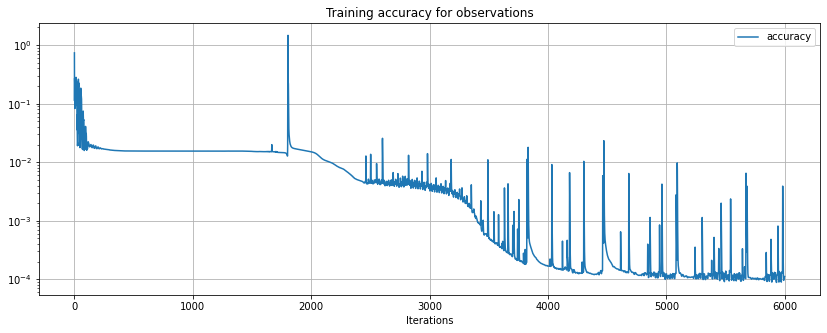

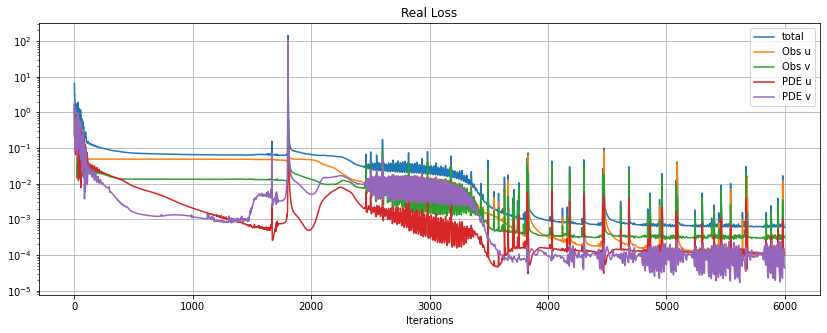

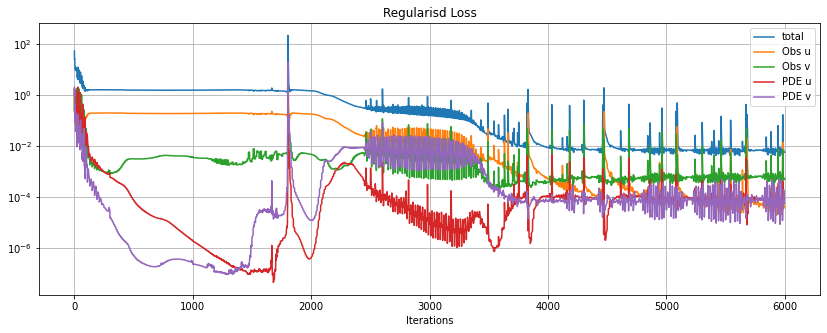

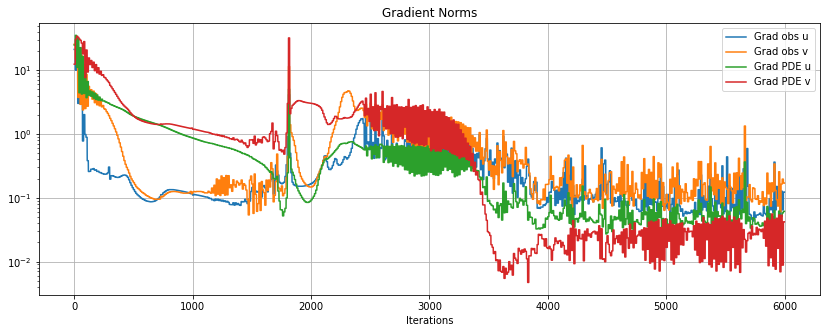

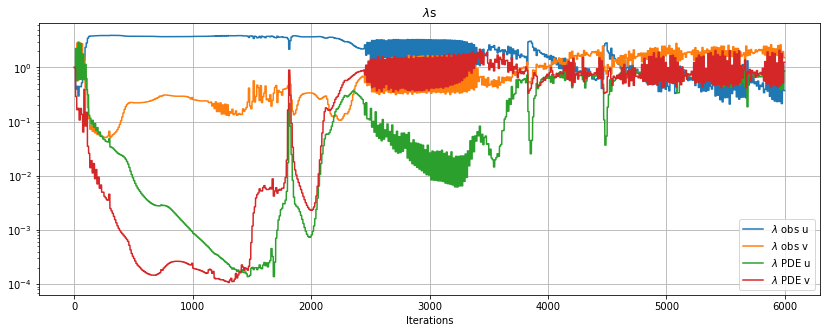

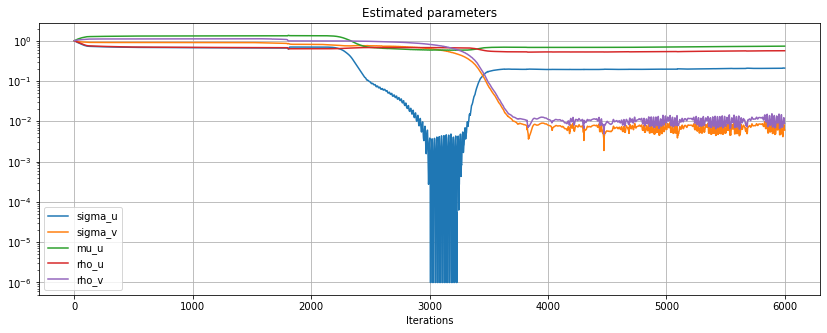

In [30]:
plot_result(merge_dict(results_KM), start=0
            , param_names=["sigma_u", "sigma_v","mu_u","rho_u","rho_v"])

In [12]:
print(pde_resKM.trainables_str())

sigma_u: 0.20914 sigma_v: 0.00608 mu_u: 0.73433 rho_u: 0.56509 
rho_v: 0.00894 


In [ ]:
results_KM2 = modelKM.train(epochs = 1500,
                          batch_size = 8000,
                          dataset = ds,
                          print_interval=100,
                          stop_threshold = 1e-5,
                          sample_losses = True,              
                          sample_regularisations = True,
                          sample_gradients = True,
                          regularise=True,
                          regularise_interval=10)


Start of epoch 0
Training observations acc over epoch: 0.00011192
total loss: 0.00058444, total regularisd loss (sum of batches): 0.00544233
obs u loss: 0.00011530, obs v loss: 0.00033238
pde u loss: 0.00009515, pde v loss: 0.00004161
lambda obs u: 0.37415223, lambda obs v: 1.51500547
lambda pde u: 0.86381298, lambda pde v: 1.24702932
sigma_u: 0.20911 sigma_v: 0.00615 mu_u: 0.73435 rho_u: 0.56514 
rho_v: 0.00891 
Time taken: 15.40s

Start of epoch 100
Training observations acc over epoch: 0.00009199
total loss: 0.00067003, total regularisd loss (sum of batches): 0.00711526
obs u loss: 0.00009437, obs v loss: 0.00027360
pde u loss: 0.00011980, pde v loss: 0.00018226
lambda obs u: 0.32193553, lambda obs v: 1.48979185
lambda pde u: 0.69409636, lambda pde v: 1.49417625
sigma_u: 0.20874 sigma_v: 0.00770 mu_u: 0.73668 rho_u: 0.56830 
rho_v: 0.01185 
Time taken: 548.11s

Start of epoch 200
Training observations acc over epoch: 0.00009338
total loss: 0.00069918, total regularisd loss (sum of 

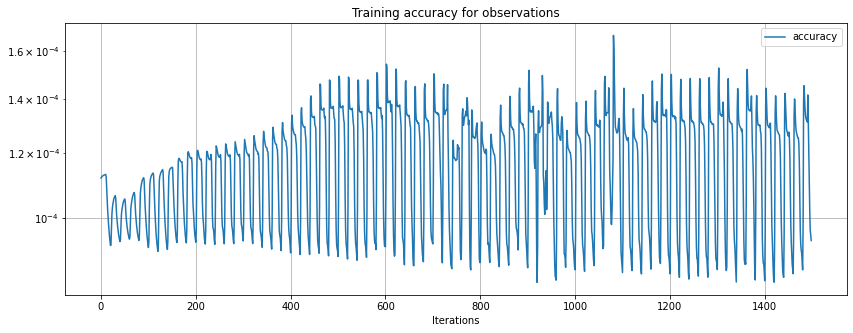

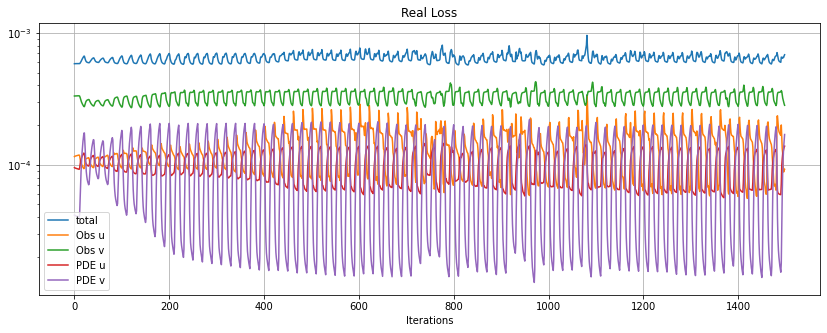

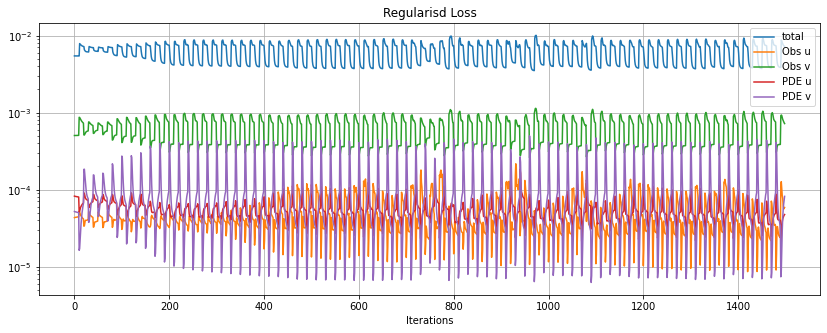

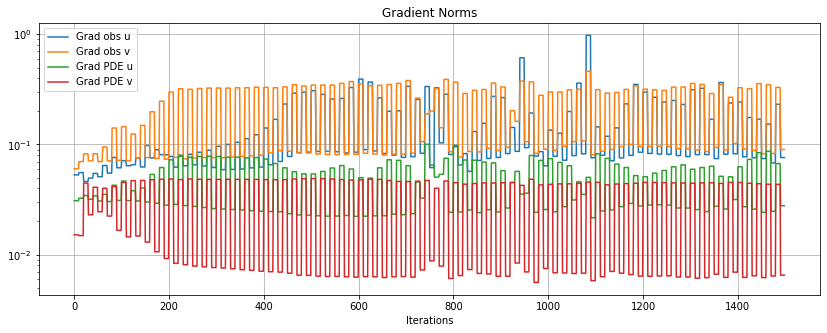

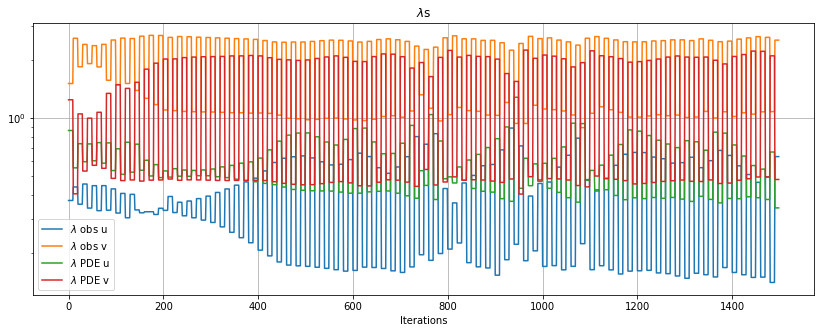

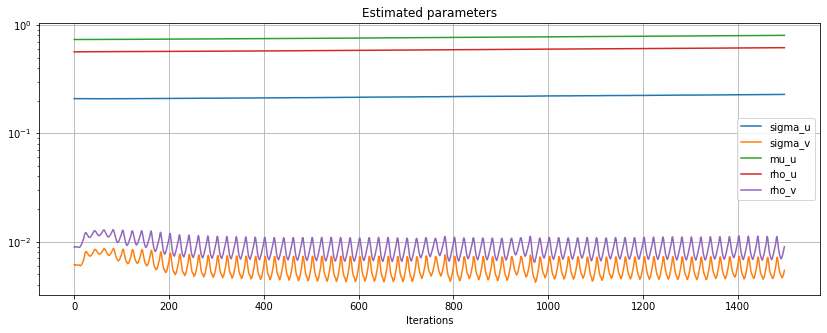

In [34]:
plot_result(merge_dict(results_KM2), start=0
            , param_names=["sigma_u", "sigma_v","mu_u","rho_u","rho_v"])

In [35]:
print(pde_resKM.trainables_str())

sigma_u: 0.22867 sigma_v: 0.00572 mu_u: 0.80233 rho_u: 0.61712 
rho_v: 0.00939 


In [36]:
modelKM.save(".","modelKM__256_kappa_zero_7500")

In [7]:
modelKM = tu.TINN.restore(".","modelKM__256_kappa_zero_7500", ds)
pde_resKM = modelKM.pde_residual
pinnKM = modelKM.pinn

2022-11-11 12:07:54.042738: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-11-11 12:07:55.376145: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


In [14]:
x_domain = simulation.L[0] * np.linspace(0, 1, simulation.n[0])
y_domain = simulation.L[1] * np.linspace(0, 1, simulation.n[1])
x_size = simulation.n[0]
y_size = simulation.n[1]
N2 = x_size * y_size


#T_test_index = -1#119
#T =224
index =5
T = t_star[index]
#print(t_star[T_test_index])
print(T)
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(T, N2)  # 1 x N2
inputs = np.vstack([XX_test, YY_test, TT_test]).T

352.0


In [14]:
import rdsolver

In [37]:
# Load a standard ASDM model
D, beta, gamma, f, f_args, homo_ss = rdsolver.models.asdm()

# Set up the space and time grid
n = (simulation.n[0], simulation.n[1])
L = (simulation.L[0], simulation.L[1])
t = t_star#np.linspace(0, 100000, 256)

# Include the estimated params
D_u = pde_resKM.D_u.get_value(None).numpy()#0.01558*const1#0.005
D_v = pde_resKM.D_v.get_value(None).numpy()#0.03886*const2#0.2
D[0] = D_u # D_a
D[1] = D_v # D_s
beta[0] = pde_resKM.sigma_u.get_value(None).numpy()#0.00040#0.00097*const1# sigma_a
beta[1] = pde_resKM.sigma_v.get_value(None).numpy()#0.01521#0.00345*const2 # sigma_s
gamma[0,0] = -pde_resKM.mu_u.get_value(None).numpy()#-0.01046#-0.03316*const1#mu_a
# rho_a,  rho_s, kappa_a
f_args = (pde_resKM.rho_u.get_value(None).numpy(), 
          pde_resKM.rho_v.get_value(None).numpy(),
          pde_resKM.kappa_u.get_value(None).numpy())
          #pde_resKM.kappa_u.get_value(None).numpy())


# Initial condition and solve
c0 = rdsolver.initial_condition(uniform_conc=homo_ss, n=n, L=L)
#c0 = data[:, :, :, 0]
c = rdsolver.solve(c0, t, D=D, beta=beta, gamma=gamma, f=f, f_args=f_args, L=L)

# Interpolate the solution
c_interp = rdsolver.viz.interpolate_concs(c)

100%|██████████| 6/6 [13:31<00:00, 135.32s/it]


In [15]:
parameters = [pde_resKM.mu_u, pde_resKM.rho_u, pde_resKM.rho_v, pde_resKM.sigma_u, pde_resKM.sigma_v]
ret = minimize_parameters(pde_resKM, pinnKM, inputs, parameters)

In [ ]:
'sigma_u': 0.1, 'sigma_v': 1.0, 'mu_u': 1.0, 'rho_u': 1.0, 
'rho_v': 1.25, 'kappa_u': 0.0

In [16]:
ret.x

array([0.67977342, 0.51844135, 0.00407105, 0.19675243, 0.00255166])

In [11]:
ret.x

array([1.61590997, 1.22830669, 0.05892655, 0.4713037 , 0.04341765])

In [17]:
import rdsolver
# Load a standard ASDM model
D, beta, gamma, f, f_args, homo_ss = rdsolver.models.asdm()

# Set up the space and time grid
n = (simulation.n[0], simulation.n[1])
L = (simulation.L[0], simulation.L[1])
t = t_star#np.linspace(0, 100000, 256)

# Include the estimated params
D_u = pde_resKM.D_u.get_value(None).numpy()#0.01558*const1#0.005
D_v = pde_resKM.D_v.get_value(None).numpy()#0.03886*const2#0.2
D[0] = D_u # D_a
D[1] = D_v # D_s
beta[0] = ret.x[3]#pde_resKM.sigma_u.get_value(None).numpy()#0.00040#0.00097*const1# sigma_a
beta[1] = ret.x[4]#pde_resKM.sigma_v.get_value(None).numpy()#0.01521#0.00345*const2 # sigma_s
gamma[0,0] = -ret.x[0]#-pde_resKM.mu_u.get_value(None).numpy()#-0.01046#-0.03316*const1#mu_a
# rho_a,  rho_s, kappa_a
f_args = (ret.x[1],#pde_resKM.rho_u.get_value(None).numpy(), 
          ret.x[2],#pde_resKM.rho_v.get_value(None).numpy(),
          pde_resKM.kappa_u.get_value(None).numpy())
          #pde_resKM.kappa_u.get_value(None).numpy())


# Initial condition and solve
c0 = rdsolver.initial_condition(uniform_conc=homo_ss, n=n, L=L)
#c0 = data[:, :, :, 0]
c = rdsolver.solve(c0, t, D=D, beta=beta, gamma=gamma, f=f, f_args=f_args, L=L)

# Interpolate the solution
c_interp = rdsolver.viz.interpolate_concs(c)

100%|██████████| 6/6 [07:43<00:00, 77.17s/it] 


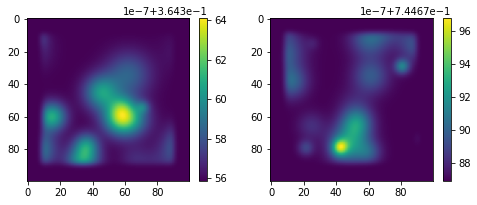

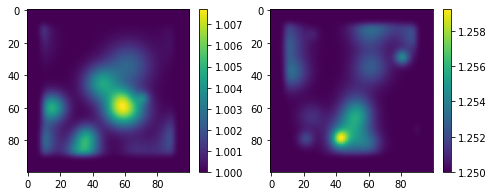

In [18]:
# model_params_fig = {'training_data_size': T*N,#T*32,
#                 'pde_data_size': (T*N),
#                 'boundary_data_size':((x_size + y_size)*T)//(8),
#                 'signal_to_noise':0.20,
#                 'shuffle':False}
# T = t_star.shape[0]    
    
# L = 50
# x_size = data.shape[1]
# y_size = data.shape[2]
# N = x_size*y_size

# dataset_fig = create_dataset(data, t_star, N, T, L, **model_params_fig)
# obs_Y_fig = dataset_fig['obs_output']

# _ = plt.figure(figsize=(8,4))
# plt.title("Original")
# plt.subplot(121)
# plt.imshow(data[0,:,:, -1])
# plt.colorbar(shrink=.75)
# plt.subplot(122)
# plt.imshow(data[1,:,:, -1])
# plt.colorbar(shrink=.75)
# plt.show()

# _ = plt.figure(figsize=(8,4))
# plt.title("20% Noise")
# plt.subplot(121)
# plt.imshow(obs_Y_fig[(T-1)*N:, 0].reshape(x_size, y_size))
# plt.colorbar(shrink=.75)
# plt.subplot(122)
# plt.imshow(obs_Y_fig[(T-1)*N:, 1].reshape(x_size, y_size))
# plt.colorbar(shrink=.75)
# plt.show()

_ = plt.figure(figsize=(8,4))
plt.title("Solution by estimates")
plt.subplot(121)
plt.imshow(c[0, :,:,-1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(c[1, :,:,-1])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.title("Initial condition")
plt.subplot(121)
plt.imshow(c[0, :,:,0])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(c[1, :,:,0])
plt.colorbar(shrink=.75)
plt.show()

# Second test: No fixed parameter but more data for training

In [32]:
x_domain = simulation.L[0] * np.linspace(0, 1, simulation.n[0])
y_domain = simulation.L[1] * np.linspace(0, 1, simulation.n[1])
x_size = simulation.n[0]
y_size = simulation.n[1]
N2 = x_size * y_size


#T_test_index = -1#119
#T =224
index =5
T = t_star[index]
T = 10000
#print(t_star[T_test_index])
print(T)
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(T, N2)  # 1 x N2
inputs = np.vstack([XX_test, YY_test, TT_test]).T

10000


In [33]:
output_test = pinnKM(np.vstack([XX_test, YY_test, TT_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((x_size, y_size)) for i in range(output_test.shape[1])]) 

In [34]:
t_star

array([ 32.,  96., 160., 224., 288., 352.])

In [35]:
test_d = np.vstack([XX_test, YY_test, TT_test]).T
test_outputs = np.zeros((test_d.shape[0], 2))
test_pde_u = np.zeros(test_d.shape[0])
test_pde_v = np.zeros(test_d.shape[0])
outs, pde_u, pde_v = pde_resKM.residual(pinnKM, test_d)
test_outputs = np.array([test_outputs[..., i].reshape(x_size, y_size) for i in range(2)])
#test_outputs[i] = outs.numpy()
test_pde_u = pde_u.numpy().reshape(x_size, y_size)
test_pde_v = pde_v.numpy().reshape(x_size, y_size)

In [36]:
print(np.sqrt(np.mean((output_test[0, ...]-data[0,:,:, index])**2)))
print(np.sqrt(np.mean((output_test[1, ...]-data[1,:,:, index])**2)))

1.6779620254935823
1.8921454792980887


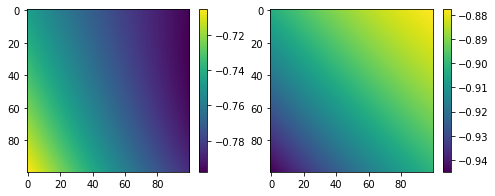

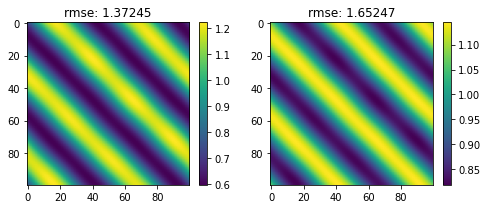

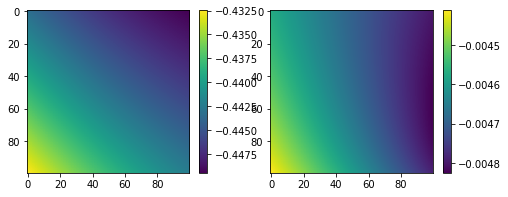

In [37]:

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(output_test[0, ...])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(output_test[1, ...])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
rmse = np.sqrt(np.mean( (output_test[0, ...]-data[0,:,:, index])**2 ))/np.max(data[0,:,:, index])
plt.title(f"rmse: {rmse:.5f}")
plt.imshow(data[0,:,:, index])
plt.colorbar(shrink=.75)
plt.subplot(122)
rmse = np.sqrt(np.mean( (output_test[1, ...]-data[1,:,:, index])**2 ))/np.max(data[1,:,:, index])
plt.title(f"rmse: {rmse:.5f}")
plt.imshow(data[1,:,:, index])
plt.colorbar(shrink=.75)
plt.show()

#index = 0
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(test_pde_u)
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(test_pde_v)
plt.colorbar(shrink=.75)
plt.show()

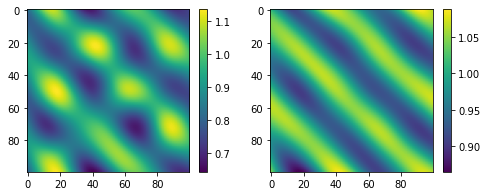

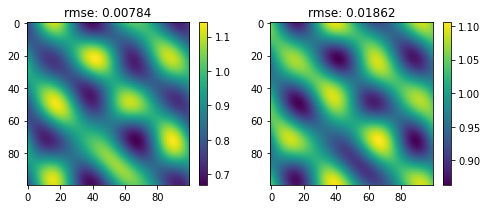

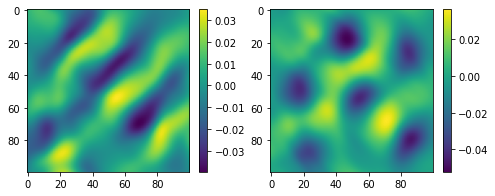

In [25]:

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(output_test[0, ...])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(output_test[1, ...])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
rmse = np.sqrt(np.mean( (output_test[0, ...]-data[0,:,:, index])**2 ))/np.max(data[0,:,:, index])
plt.title(f"rmse: {rmse:.5f}")
plt.imshow(data[0,:,:, index])
plt.colorbar(shrink=.75)
plt.subplot(122)
rmse = np.sqrt(np.mean( (output_test[1, ...]-data[1,:,:, index])**2 ))/np.max(data[1,:,:, index])
plt.title(f"rmse: {rmse:.5f}")
plt.imshow(data[1,:,:, index])
plt.colorbar(shrink=.75)
plt.show()

#index = 0
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(test_pde_u)
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(test_pde_v)
plt.colorbar(shrink=.75)
plt.show()

In [58]:
 from collections.abc import Iterable
key_vals = [(key,v.tf_var.numpy()) for key,v in pde_resKM.__dict__.items() if isinstance(v, PDE_Parameter)]
[(key, v[0] if isinstance(v, Iterable) else v) for key, v in key_vals]

[('D_u', 0.1),
 ('D_v', 1.0),
 ('sigma_u', 0.22866644008523915),
 ('sigma_v', 0.005723287917705418),
 ('mu_u', 0.8023272402081042),
 ('rho_u', 0.6171208920080262),
 ('rho_v', 0.009389079640566301),
 ('kappa_u', 0.0)]

In [52]:
pde_resKM.trainables_str()

'sigma_u: 0.00000 sigma_v: 0.01172 mu_u: 0.06077 rho_u: 0.10885 \nrho_v: 0.02535 kappa_u: 0.64143 '

In [50]:
a

[('D_u', 0.1),
 ('D_v', 1.0),
 ('sigma_u', array([0.22866644])),
 ('sigma_v', array([0.00572329])),
 ('mu_u', array([0.80232724])),
 ('rho_u', array([0.61712089])),
 ('rho_v', array([0.00938908])),
 ('kappa_u', 0.0)]

In [57]:
 from collections.abc import Iterable
isinstance(a[2][0], Iterable)

True